In [2]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=cb728fc9ab48df4e9dae4c5ac90316a2123308fb1f72aacb2933e354647b1e36
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=17c26838dc7021351b26e9a17dcb21c8baeb54dbde24b0ae4319389902c6cb62
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


**Importing Required Modules**

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import segmentation_models_pytorch as smp
from sklearn.metrics import confusion_matrix
import cv2
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

**Uploading dataset and preprocessing**

In [7]:
# Define paths (adjust according to dataset location on Kaggle)
image_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/train'
mask_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/train'

In [8]:
# Collect image and mask paths
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
mask_files = [f.replace('_sat.jpg', '_mask.png') for f in image_files]

image_paths = [os.path.join(image_dir, f) for f in image_files]
mask_paths = [os.path.join(mask_dir, f) for f in mask_files]

# Verify that all masks exist
for mp in mask_paths:
    if not os.path.exists(mp):
        raise FileNotFoundError(f"Mask {mp} not found")

# Split into train and validation
indices = np.random.permutation(len(image_paths))
split = int(0.8 * len(indices))
train_indices = indices[:split]
val_indices = indices[split:]

In [9]:
train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]

In [10]:
# Define color to class mapping (adjust according to dataset documentation)
colors = np.array([
    [0, 255, 255],   # Urban land (0)
    [255, 255, 0],    # Agriculture (1)
    [255, 0, 255],    # Rangeland (2)
    [0, 255, 0],      # Forest (3)
    [0, 0, 255],      # Water (4)
    [255, 255, 255],  # Barren (5)
    [0, 0, 0]         # Unknown (6)
], dtype=np.uint8)

# Define transforms
transform_train = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

transform_val = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [11]:
class DeepGlobeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.colors = colors

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # ... (image loading code remains the same)
        image = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        mask_rgb = cv2.cvtColor(cv2.imread(self.mask_paths[idx]), cv2.COLOR_BGR2RGB)
        
        # Convert mask to class indices
        h, w = mask_rgb.shape[:2]
        mask_flat = mask_rgb.reshape(-1, 3)
        color_diff = np.abs(mask_flat[:, None, :] - self.colors[None, :, :])
        distance = np.sum(color_diff, axis=2)
        class_indices = np.argmin(distance, axis=1)
        class_mask = class_indices.reshape(h, w)

        if self.transform:
            transformed = self.transform(image=image, mask=class_mask)
            image = transformed['image']
            mask = transformed['mask'].long()  # Explicit cast to long
        else:
            image = A.ToTensorV2()(image=image)['image']
            mask = torch.from_numpy(class_mask).long()  # Already correct

        return image, mask

**Creating data Loaders**

In [12]:
# Create datasets and dataloaders
train_dataset = DeepGlobeDataset(train_image_paths, train_mask_paths, transform_train)
val_dataset = DeepGlobeDataset(val_image_paths, val_mask_paths, transform_val)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

**Creating Model and training process**

In [14]:
# Model setup
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=7
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 411MB/s]


cuda


In [11]:
# Loss and optimizer
ce_loss = nn.CrossEntropyLoss()
dice_loss = smp.losses.DiceLoss(mode='multiclass', classes=7)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
best_val_miou = 0.0

In [12]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_cm = np.zeros((7, 7), dtype=np.int64)
    
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss_ce = ce_loss(outputs, masks)
        loss_dice = dice_loss(outputs, masks)
        loss = loss_ce + loss_dice
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Update confusion matrix
        preds = torch.argmax(outputs.detach(), dim=1)
        masks_np = masks.cpu().numpy().flatten()
        preds_np = preds.cpu().numpy().flatten()
        cm = confusion_matrix(masks_np, preds_np, labels=range(7))
        total_cm += cm
    
    # Calculate metrics
    iou_per_class = []
    for i in range(7):
        tp = total_cm[i, i]
        fp = total_cm[:, i].sum() - tp
        fn = total_cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-9)
        iou_per_class.append(iou)
    miou = np.mean(iou_per_class)
    pixel_acc = np.diag(total_cm).sum() / total_cm.sum()
    
    print(f'Train Loss: {running_loss / len(train_loader):.4f}, mIoU: {miou:.4f}, Pixel Acc: {pixel_acc:.4f}')
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_total_cm = np.zeros((7, 7), dtype=np.int64)
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss_ce = ce_loss(outputs, masks)
            loss_dice = dice_loss(outputs, masks)
            loss = loss_ce + loss_dice
            val_running_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            masks_np = masks.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            cm = confusion_matrix(masks_np, preds_np, labels=range(7))
            val_total_cm += cm
    
    # Calculate validation metrics
    val_iou_per_class = []
    for i in range(7):
        tp = val_total_cm[i, i]
        fp = val_total_cm[:, i].sum() - tp
        fn = val_total_cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-9)
        val_iou_per_class.append(iou)
    val_miou = np.mean(val_iou_per_class)
    val_pixel_acc = np.diag(val_total_cm).sum() / val_total_cm.sum()
    
    print(f'Val Loss: {val_running_loss / len(val_loader):.4f}, Val mIoU: {val_miou:.4f}, Val Pixel Acc: {val_pixel_acc:.4f}')
    
    # Save best model
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Best model saved with mIoU: {best_val_miou:.4f}')

print('Training Complete!')

Epoch 1/20 - Training: 100%|██████████| 81/81 [09:47<00:00,  7.25s/it]


Train Loss: 2.0913, mIoU: 0.2487, Pixel Acc: 0.5907


Epoch 1/20 - Validation: 100%|██████████| 21/21 [02:24<00:00,  6.90s/it]


Val Loss: 1.4814, Val mIoU: 0.4373, Val Pixel Acc: 0.7986
Best model saved with mIoU: 0.4373


Epoch 2/20 - Training: 100%|██████████| 81/81 [09:34<00:00,  7.09s/it]


Train Loss: 1.6188, mIoU: 0.3810, Pixel Acc: 0.7311


Epoch 2/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.79s/it]


Val Loss: 1.3406, Val mIoU: 0.4409, Val Pixel Acc: 0.7815
Best model saved with mIoU: 0.4409


Epoch 3/20 - Training: 100%|██████████| 81/81 [09:36<00:00,  7.11s/it]


Train Loss: 1.4247, mIoU: 0.4155, Pixel Acc: 0.7530


Epoch 3/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.80s/it]


Val Loss: 1.1795, Val mIoU: 0.4990, Val Pixel Acc: 0.8315
Best model saved with mIoU: 0.4990


Epoch 4/20 - Training: 100%|██████████| 81/81 [09:33<00:00,  7.08s/it]


Train Loss: 1.3306, mIoU: 0.4380, Pixel Acc: 0.7688


Epoch 4/20 - Validation: 100%|██████████| 21/21 [02:20<00:00,  6.71s/it]


Val Loss: 1.1360, Val mIoU: 0.4888, Val Pixel Acc: 0.8100


Epoch 5/20 - Training: 100%|██████████| 81/81 [09:30<00:00,  7.04s/it]


Train Loss: 1.2171, mIoU: 0.4752, Pixel Acc: 0.7934


Epoch 5/20 - Validation: 100%|██████████| 21/21 [02:20<00:00,  6.70s/it]


Val Loss: 1.0602, Val mIoU: 0.5041, Val Pixel Acc: 0.8334
Best model saved with mIoU: 0.5041


Epoch 6/20 - Training: 100%|██████████| 81/81 [09:31<00:00,  7.06s/it]


Train Loss: 1.2073, mIoU: 0.4854, Pixel Acc: 0.7948


Epoch 6/20 - Validation: 100%|██████████| 21/21 [02:21<00:00,  6.72s/it]


Val Loss: 1.0107, Val mIoU: 0.5475, Val Pixel Acc: 0.8455
Best model saved with mIoU: 0.5475


Epoch 7/20 - Training: 100%|██████████| 81/81 [09:36<00:00,  7.12s/it]


Train Loss: 1.1644, mIoU: 0.4902, Pixel Acc: 0.7947


Epoch 7/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.77s/it]


Val Loss: 1.0811, Val mIoU: 0.5038, Val Pixel Acc: 0.8010


Epoch 8/20 - Training: 100%|██████████| 81/81 [09:33<00:00,  7.08s/it]


Train Loss: 1.0624, mIoU: 0.5221, Pixel Acc: 0.8207


Epoch 8/20 - Validation: 100%|██████████| 21/21 [02:21<00:00,  6.72s/it]


Val Loss: 0.9740, Val mIoU: 0.5439, Val Pixel Acc: 0.8546


Epoch 9/20 - Training: 100%|██████████| 81/81 [09:33<00:00,  7.08s/it]


Train Loss: 1.0277, mIoU: 0.5290, Pixel Acc: 0.8220


Epoch 9/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.79s/it]


Val Loss: 0.9720, Val mIoU: 0.5418, Val Pixel Acc: 0.8327


Epoch 10/20 - Training: 100%|██████████| 81/81 [09:28<00:00,  7.02s/it]


Train Loss: 1.0148, mIoU: 0.5379, Pixel Acc: 0.8276


Epoch 10/20 - Validation: 100%|██████████| 21/21 [02:21<00:00,  6.76s/it]


Val Loss: 0.9297, Val mIoU: 0.5443, Val Pixel Acc: 0.8452


Epoch 11/20 - Training: 100%|██████████| 81/81 [09:30<00:00,  7.05s/it]


Train Loss: 0.9816, mIoU: 0.5484, Pixel Acc: 0.8340


Epoch 11/20 - Validation: 100%|██████████| 21/21 [02:21<00:00,  6.74s/it]


Val Loss: 0.9153, Val mIoU: 0.5582, Val Pixel Acc: 0.8483
Best model saved with mIoU: 0.5582


Epoch 12/20 - Training: 100%|██████████| 81/81 [09:31<00:00,  7.06s/it]


Train Loss: 0.9741, mIoU: 0.5480, Pixel Acc: 0.8334


Epoch 12/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.78s/it]


Val Loss: 0.9186, Val mIoU: 0.5613, Val Pixel Acc: 0.8475
Best model saved with mIoU: 0.5613


Epoch 13/20 - Training: 100%|██████████| 81/81 [09:34<00:00,  7.10s/it]


Train Loss: 0.9013, mIoU: 0.5737, Pixel Acc: 0.8510


Epoch 13/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.81s/it]


Val Loss: 0.8825, Val mIoU: 0.5573, Val Pixel Acc: 0.8513


Epoch 14/20 - Training: 100%|██████████| 81/81 [09:37<00:00,  7.13s/it]


Train Loss: 0.8979, mIoU: 0.5738, Pixel Acc: 0.8529


Epoch 14/20 - Validation: 100%|██████████| 21/21 [02:20<00:00,  6.68s/it]


Val Loss: 0.8920, Val mIoU: 0.5569, Val Pixel Acc: 0.8367


Epoch 15/20 - Training: 100%|██████████| 81/81 [09:30<00:00,  7.04s/it]


Train Loss: 0.8845, mIoU: 0.5871, Pixel Acc: 0.8594


Epoch 15/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.80s/it]


Val Loss: 0.8685, Val mIoU: 0.5699, Val Pixel Acc: 0.8520
Best model saved with mIoU: 0.5699


Epoch 16/20 - Training: 100%|██████████| 81/81 [09:30<00:00,  7.05s/it]


Train Loss: 0.8498, mIoU: 0.5866, Pixel Acc: 0.8606


Epoch 16/20 - Validation: 100%|██████████| 21/21 [02:21<00:00,  6.76s/it]


Val Loss: 0.9098, Val mIoU: 0.5687, Val Pixel Acc: 0.8363


Epoch 17/20 - Training: 100%|██████████| 81/81 [09:30<00:00,  7.04s/it]


Train Loss: 0.8596, mIoU: 0.5812, Pixel Acc: 0.8602


Epoch 17/20 - Validation: 100%|██████████| 21/21 [02:21<00:00,  6.75s/it]


Val Loss: 0.8329, Val mIoU: 0.5754, Val Pixel Acc: 0.8670
Best model saved with mIoU: 0.5754


Epoch 18/20 - Training: 100%|██████████| 81/81 [09:31<00:00,  7.05s/it]


Train Loss: 0.8008, mIoU: 0.6092, Pixel Acc: 0.8741


Epoch 18/20 - Validation: 100%|██████████| 21/21 [02:21<00:00,  6.74s/it]


Val Loss: 0.8177, Val mIoU: 0.5833, Val Pixel Acc: 0.8690
Best model saved with mIoU: 0.5833


Epoch 19/20 - Training: 100%|██████████| 81/81 [09:32<00:00,  7.07s/it]


Train Loss: 0.7981, mIoU: 0.6089, Pixel Acc: 0.8759


Epoch 19/20 - Validation: 100%|██████████| 21/21 [02:25<00:00,  6.92s/it]


Val Loss: 0.8622, Val mIoU: 0.5682, Val Pixel Acc: 0.8534


Epoch 20/20 - Training: 100%|██████████| 81/81 [09:33<00:00,  7.07s/it]


Train Loss: 0.8081, mIoU: 0.5990, Pixel Acc: 0.8672


Epoch 20/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.78s/it]

Val Loss: 0.9140, Val mIoU: 0.5674, Val Pixel Acc: 0.8461
Training Complete!


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, device, colors, num_samples=3):
    """
    Visualize original image, ground truth mask, and predicted mask
    Args:
        model: Trained model
        dataset: Dataset object (e.g., val_dataset)
        device: cuda/cpu
        colors: Color mapping array
        num_samples: Number of samples to visualize
    """
    model.eval()
    indices = np.random.choice(len(dataset), num_samples)
    
    plt.figure(figsize=(18, 4*num_samples))
    
    for i, idx in enumerate(indices):
        # Get data
        image, true_mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        
        # Prediction
        with torch.no_grad():
            output = model(image_tensor)
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
        
        # Convert image to display format
        image = image.cpu().numpy().transpose(1, 2, 0)
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        image = image.astype(np.uint8)
        
        # Convert masks to RGB
        def mask_to_rgb(mask_array):
            h, w = mask_array.shape
            rgb = np.zeros((h, w, 3), dtype=np.uint8)
            for class_idx, color in enumerate(colors):
                rgb[mask_array == class_idx] = color
            return rgb
            
        true_mask_rgb = mask_to_rgb(true_mask.numpy())
        pred_mask_rgb = mask_to_rgb(pred_mask)
        
        # Plot
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(image)
        plt.title(f"Sample {i+1}\nOriginal Image")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(true_mask_rgb)
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pred_mask_rgb)
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
# Define colors (must match your dataset's class order)
colors = np.array([
    [0, 255, 255],   # Urban land
    [255, 255, 0],   # Agriculture
    [255, 0, 255],   # Rangeland
    [0, 255, 0],     # Forest
    [0, 0, 255],     # Water
    [255, 255, 255], # Barren
    [0, 0, 0]        # Unknown
])

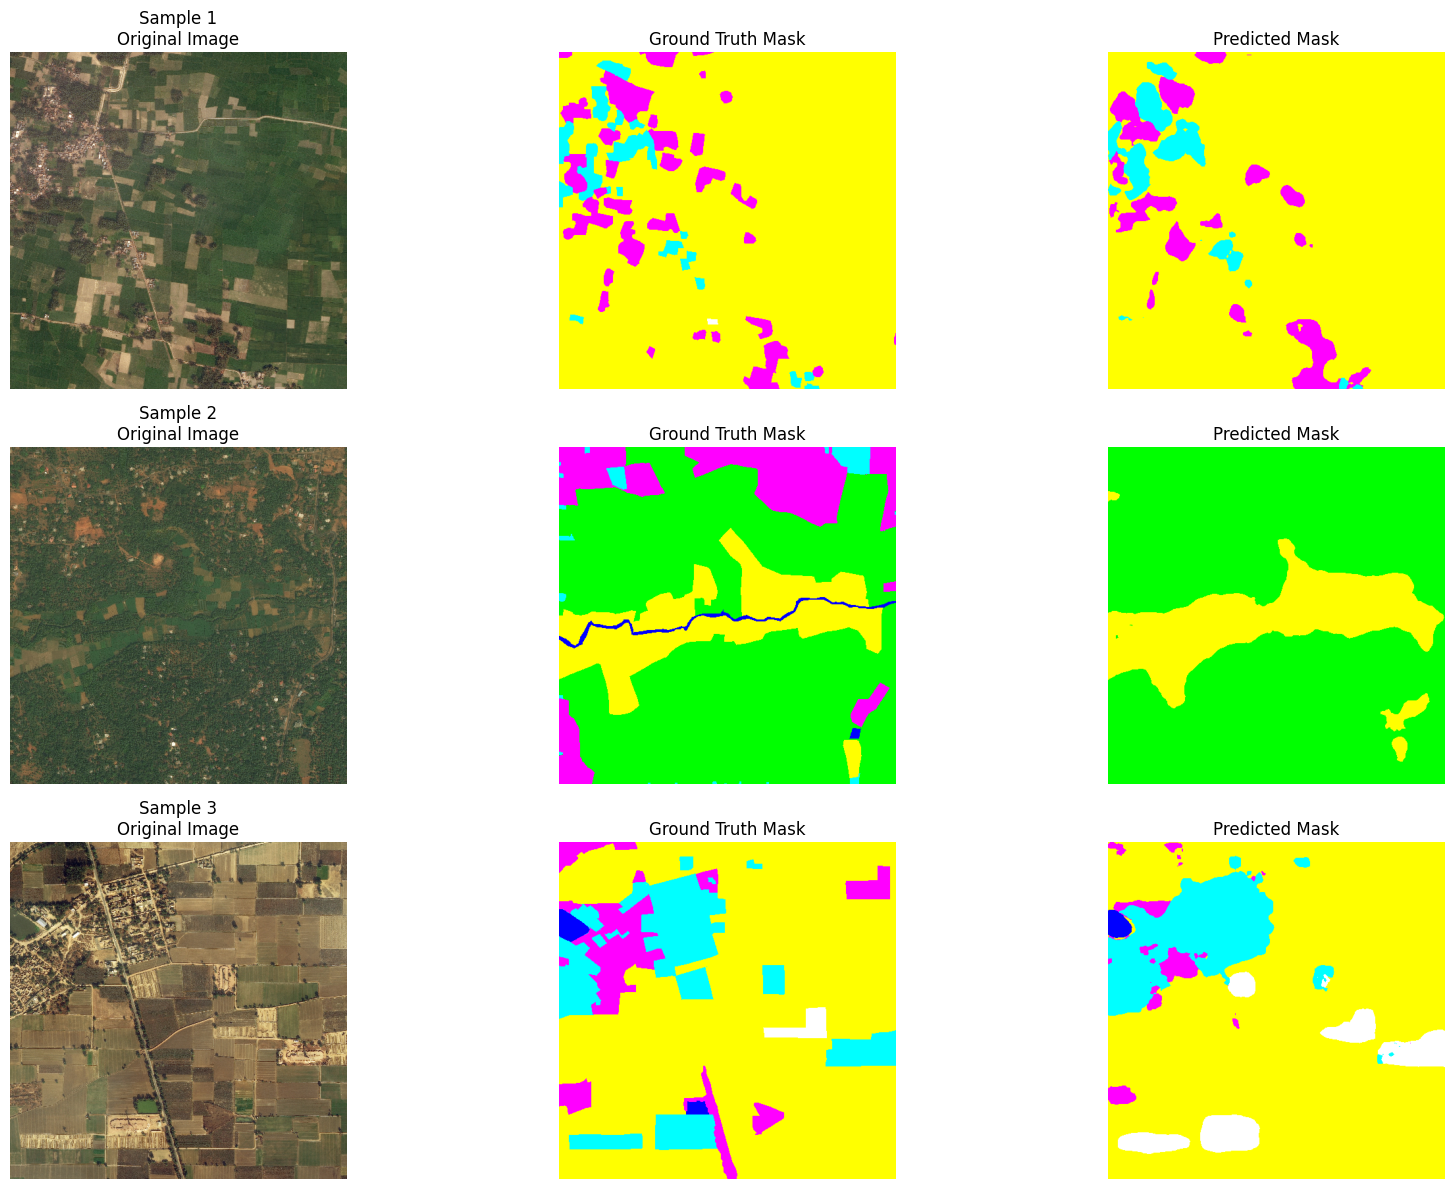

In [27]:
# Usage after training
visualize_predictions(
    model=model,
    dataset=val_dataset,  # Use your validation dataset
    device=device,
    colors=colors,
    num_samples=3  # Number of examples to show
)

**Evaluating the Model**

In [15]:
def evaluate_model(model_path, val_loader, device):
    # Load best model
    model = smp.Unet(
        encoder_name='resnet34',
        encoder_weights='imagenet',
        in_channels=3,
        classes=7
    )
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Initialize metrics
    dice_loss = smp.losses.DiceLoss(mode='multiclass', classes=7)
    total_dice = 0.0
    total_cm = np.zeros((7, 7), dtype=np.int64)
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Calculate Dice Loss
            loss_dice = dice_loss(outputs, masks)
            total_dice += loss_dice.item()
            
            # For other metrics
            preds = torch.argmax(outputs, dim=1)
            masks_np = masks.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            cm = confusion_matrix(masks_np, preds_np, labels=range(7))
            total_cm += cm
    
    # Calculate metrics
    val_dice = total_dice / len(val_loader)
    
    val_iou_per_class = []
    for i in range(7):
        tp = total_cm[i, i]
        fp = total_cm[:, i].sum() - tp
        fn = total_cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-9)
        val_iou_per_class.append(iou)
    val_miou = np.mean(val_iou_per_class)
    val_pixel_acc = np.diag(total_cm).sum() / total_cm.sum()
    
    print(f"\nFinal Evaluation Results:")
    print(f"Dice Loss: {val_dice:.4f}")
    print(f"mIoU: {val_miou:.4f}")
    print(f"Pixel Accuracy: {val_pixel_acc:.4f}")

# Usage
evaluate_model(
    model_path='/kaggle/input/unet/pytorch/default/1/best_model.pth',
    val_loader=val_loader,
    device=device
)

<ipython-input-15-83fa755e4c7d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Evaluating: 100%|██████████| 21/21 [02:27<00:0


Final Evaluation Results:
Dice Loss: 0.3963
mIoU: 0.5833
Pixel Accuracy: 0.8690
